In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

In [3]:
milk = pd.read_csv('EURUSD60.csv')

In [4]:
milk.shape

(15766, 7)

In [5]:
columnName = ['a','b','c','d','e','f','g']

In [6]:
milk.columns = columnName

In [7]:
milk.head()


,a,b,c,d,e,f,g
0,2016.07.28,14:00,1.10830,1.10884,1.10786,1.10814,6698
1,2016.07.28,15:00,1.10824,1.11028,1.10822,1.10990,8333
2,2016.07.28,16:00,1.10991,1.11050,1.10893,1.11048,9670
3,2016.07.28,17:00,1.11049,1.11074,1.10816,1.10827,9241
4,2016.07.28,18:00,1.10829,1.10941,1.10792,1.10931,6026


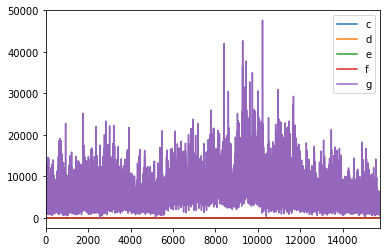

In [8]:
milk.plot()

In [9]:
train_set = milk[0:10000]
train_set = train_set[['c']]*100

In [10]:
test_set = milk[10000:10120]
test_set = test_set[['c']]*100

In [11]:
test_set.shape

(120, 1)

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
train_scaled = scaler.fit_transform(train_set)

In [15]:
test_scaled = scaler.transform(test_set)

In [16]:
def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    
    # STEP 1: Use np.random.randint to set a random starting point index for the batch.
    # Remember that each batch needs have the same number of steps in it.
    # This means you should limit the starting point to len(data)-steps
    
    # STEP 2: Now that you have a starting index you'll need to index the data from
    # the random start to random start + steps. Then reshape this data to be (1,steps)
    
    # STEP 3: Return the batches. You'll have two batches to return y[:,:-1] and y[:,1:]
    # You'll need to reshape these into tensors for the RNN. Depending on your indexing it
    # will be either .reshape(-1,steps-1,1) or .reshape(-1,steps,1)

In [17]:
def next_batch(training_data,batch_size,steps):
    
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

In [18]:
# Just one feature, the time series
num_inputs = 1
# Num of steps in each batch
num_time_steps = 12
# 100 neuron layer, play with this
num_neurons = 5000
# Just one output, predicted time series
num_outputs = 1

## You can also try increasing iterations, but decreasing learning rate
# learning rate you can play with this
learning_rate = 0.03 
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 1000
# Size of the batch of data
batch_size = 1

In [19]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [20]:
X

<tf.Tensor 'Placeholder:0' shape=(?, 12, 1) dtype=float32>

In [21]:
y

<tf.Tensor 'Placeholder_1:0' shape=(?, 12, 1) dtype=float32>

In [22]:
# Also play around with GRUCell
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [23]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [24]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [25]:
init = tf.global_variables_initializer()

In [26]:
saver = tf.train.Saver()

In [27]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [ ]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./ex_time_series_model")

0 	MSE: 3.6042641e+25


In [ ]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./ex_time_series_model")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
    train_seed = list(train_scaled[-120:])
    
    ## Now create a for loop that 
    for iteration in range(120):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

In [30]:
results = scaler.inverse_transform(np.array(train_seed[120:]).reshape(120,1))

In [31]:
results.shape

(120, 1)

In [32]:
test_set['Generated'] = results

In [33]:
test_set

,c,Generated
5000,111.084,112.335136
5001,111.117,111.812508
5002,111.227,112.176643
5003,111.255,112.045769
5004,111.466,112.288963
5005,111.326,112.187088
5006,111.378,112.210808
5007,111.546,112.219780
5008,111.473,112.146904
5009,111.521,111.980026


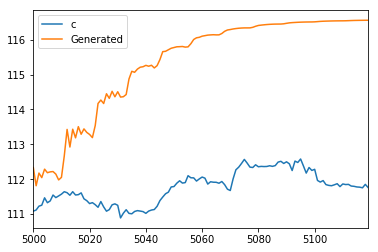

In [34]:
test_set.plot()